# Muon Chamber Geometry Basics

The `mchgeo` Python package offers a minimal interface to access some basic information about the CERN Alice Muon Chamber (aka MCH) geometry.

In order to ease interoperability with other packages (plotting for instance), the internal representation of the geometry offered by this package is in [GeoJSON](https://geojson.org) format.

The first thing to realize is that MCH is composed of 156 detection elements (one detection element being a cathode pad chamber).


In [24]:
import mchgeo
deids=mchgeo.LIST_OF_DEIDS
len(deids)

156

The 156 detection elements are organised in 5 stations of 2 chambers each. 
Each detection element has an integer ID. That detection element ID `deid` encodes the chamber number, from 1 to 10 : 

```
chamberId = deid / 100
```

In [25]:
chamber_ids = set([deid // 100 for deid in deids])
print(chamber_ids)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}


Chamber 1 is the closest (in z direction) from the interaction point (about 5.26 meters), and chamber 10 the farthest (14.45 meters).

For each detection element `mchgeo` gives you access to two kinds of information : 
- its basic 2D shape (a polygon)
- the global transformation (translation + rotation) that must be applied to position it in space

## Polygons

Given some `deid` you can get the polygon describing the outline of the corresponding detection element, within its reference plane (i.e. the polygon is 2D) 

In [56]:
pol=mchgeo.polygon(508)
print(type(pol),pol)
print(type(pol["coordinates"]))
print(type(pol["coordinates"][0]))

<class 'dict'> {'type': 'Polygon', 'coordinates': [[[-75, 20], [80, 20], [80, -6.5], [77.5, -6.5], [77.5, -7], [75, -7], [75, -7.5], [72.5, -7.5], [72.5, -8], [70, -8], [70, -8.5], [67.5, -8.5], [67.5, -10], [65, -10], [65, -11], [62.5, -11], [62.5, -13], [60, -13], [60, -15], [57.5, -15], [57.5, -17.5], [55, -17.5], [55, -20], [-75, -20], [-75, 20]]]}
<class 'list'>
<class 'list'>


Note that the `coordinates` key of the `pol` dictionary is a list of lists. That is to comply with the GeoJSON format where a polygon is described by potentially several line rings : the first (mandatory) one for the exterior and zero or more for interior holes. In the case of detection elements, we have no holes, only the exterior boundary, but we still keep the GeoJSON nesting, which explains the (probably) strange structure of the `coordinates` list.

Plotting such a polygon is made easy thanks to the [shapely](https://shapely.readthedocs.io/en/stable/index.html) Python package. 

You first have to convert the polygon dict to a proper JSON Shape using the `shape` function : 

In [57]:
from shapely.geometry import shape
de = shape(pol)
print(de)

POLYGON ((-75 20, 80 20, 80 -6.5, 77.5 -6.5, 77.5 -7, 75 -7, 75 -7.5, 72.5 -7.5, 72.5 -8, 70 -8, 70 -8.5, 67.5 -8.5, 67.5 -10, 65 -10, 65 -11, 62.5 -11, 62.5 -13, 60 -13, 60 -15, 57.5 -15, 57.5 -17.5, 55 -17.5, 55 -20, -75 -20, -75 20))


And then using e.g. `matplotlib` the shape can be displayed

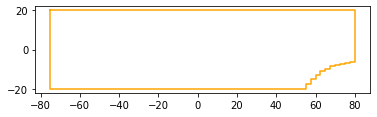

In [58]:
import matplotlib.pyplot as plt
fig,axes=plt.subplots()
axes.plot(*de.exterior.xy,color="orange")
axes.set_aspect('equal')

## Transformations

The second piece of information about each detection element, besides its polygonal shape, is the global transformation to position it in 3D space. To apply those transformations, we'll get some help from the `scikit.spatial` package which provides convenient functions to create rotation matrices using different conventions. In the transformation objet the convention used is that of [Tait-Bryan angles](https://en.wikipedia.org/wiki/Euler_angles#Tait–Bryan_angles), sometimes called yaw, pitch and roll.

In [59]:
print(mchgeo.transformation(500))

{'tx': 81.25, 'ty': -0.05197011713870941, 'tz': -955.7503840774286, 'yaw': -180, 'pitch': 0, 'roll': 179.20600000000002}


In [60]:
import scipy.spatial
import numpy as np
import shapely

def de_color(deid:int):
	index=deid%100
	colors={0:"lightcoral",1:"firebrick",2:"red",3:"coral",
	4:"chocolate",5:"sandybrown",6:"peru",7:"darkorange",
	8:"tan",9:"gold",10:"darkkhaki",11:"olive",12:"darkolivegreen",
	13:"yellowgreen",14:"chartreuse",15:"darkseagreen",16:"green",
	17:"mediumseagreen",18:"turquoise",19:"teal",20:"cyan",
	21:"deepskyblue",22:"slategrey",23:"navy",24:"slateblue",
	25:"blueviolet"}
	return colors.get(index,"black")


def plot_chamber(chamberid:int,axes):
	assert (chamberid in range(1,11)), "{} is not a valid chamber id".format(chamberid)
	deids=[deid for deid in mchgeo.LIST_OF_DEIDS if deid//100==chamberid]
	for deid in deids:
		# get a Shapely shape object from the polygon JSON representation of that detection element
		de_shape=shape(mchgeo.polygon(deid))
		# get the transformation (translation+rolation) of that detection element
		transform = mchgeo.transformation(deid)
		# create a rotation matrix from he transformation Tait-Bryan angles yaw, pitch, roll
		# rotations are made in the z-y-x order and are intrinsic ones (hence the lower case zyx)
		# yaw is around z, pitch around y and roll around x
		rot_matrix=scipy.spatial.transform.Rotation.from_euler('zyx',[transform["yaw"],transform["pitch"],transform["roll"]],degrees=True).as_matrix()
		# get the translation part of the transformation
		translation=np.array([transform["tx"],transform["ty"],transform["tz"]])
		# combine rotation and translation into a vector of size 12 that is required by the affine_transform function
		matrix=np.concatenate([rot_matrix.flatten(),translation])
		# finally apply the transformation to the detection element shape
		de = shapely.affinity.affine_transform(de_shape, matrix)
		# and plot that shape (which is now properly placed in 3D space) in 2D
		axes.plot(*de.exterior.xy,color=de_color(deid))

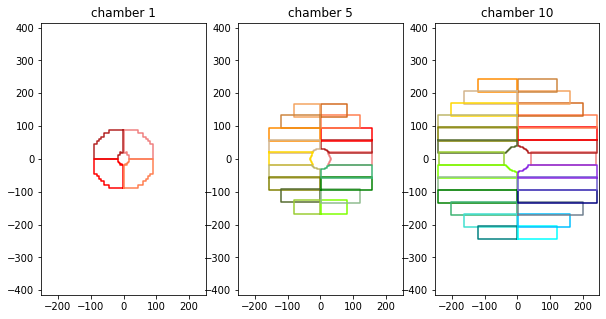

In [61]:
fig,axes=plt.subplots(1,3)
fig.set_size_inches((10,5))
chambers=[1,5,10]
for i in range(3):
	chamber_id=chambers[i]
	axes[i].set_aspect('equal',adjustable='datalim')
	axes[i].set(xlim=(-250,250))
	plot_chamber(chamber_id,axes[i])
	axes[i].set_title("chamber {}".format(chamber_id))

Note that there are some overlaps between the detection elements. That is not a plotting error : in the real detector there are indeed some overlaps in the vertical direction to avoid efficiency gaps at the detection element edges. Of course the detection element, being physical objects, can not overlap: : they are separated in the `z` direction by a few centimeters in order to get some clearance. 
Note also how chambers are bigger when they are farther away from the interaction point